# 1- Titanic Data

## Import all libraries ###

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
## The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score
from IPython.display import display,HTML
%matplotlib inline

C:\Users\Georf\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Import Titanic Data

In [5]:
X = pd.read_csv("data/train.csv", sep=",")
## pop will estract a specific column (Survived)
y = X.pop("Survived") ## This is the column i want to predict

In [10]:
## Fill missing value with mean
X["Age"].fillna(X.Age.mean(), inplace = True)
## Check if the script is correct
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 1- In this first part, we'll work only with numeric variables

In [11]:
## Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [12]:
## Fit our model using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

## Use only numeric variables
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [13]:
## Out-Of-Bag error (OOB) mesure a prediction error of Random Forest
model.oob_score_

0.1361695005913669

## Now we calculate the c-stat value

In [14]:
y_oob = model.oob_prediction_
print("c-stat :", roc_auc_score(y, y_oob))

c-stat : 0.7399551550399983


## 2- In this part, we'll work only with categoricals variables

In [16]:
## Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(dataframe):
    """
    Juts like .describe(), but returns the results for
    categorical variables only.
    """
    display(HTML(dataframe[dataframe.columns[dataframe.dtypes == "object"]].describe().to_html()))

In [17]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Newsom, Miss. Helen Monypeny",male,1601,B96 B98,S
freq,1,577,7,4,644


In [18]:
## Drop the variables I don't feel like dealing
X.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)

In [19]:
## Change the Cabin variable to be only the first letter or None
def clean_cabine(x):
    try:
        return x[0]
    except TypeError:
        return "None"
    
## Put the column value into function    
X["Cabin"] = X.Cabin.apply(clean_cabine)

In [20]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,None,S
1,1,female,38.0,1,0,71.2833,C,C
2,3,female,26.0,0,0,7.9250,None,S
3,1,female,35.0,1,0,53.1000,C,S
4,3,male,35.0,0,0,8.0500,None,S


## One-Hot-Encoding with categorical variables

In [29]:
categorical_variables = ["Sex", "Cabin", "Embarked"]

for variable in categorical_variables:
    ## Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace = True)
    ## Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix = variable)
    ## Update X to include dummies and drop the main variable
    frame = [X, dummies]
    X = pd.concat(frame, axis=1)
    X.drop([variable], axis=1, inplace= True)

In [32]:
## Look at all the columns in the dataset
def printall(X, max_rows=10):
    display(HTML(X.to_html(max_rows = max_rows)))
    
printall(X)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
888,3,29.699118,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,0,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [34]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print("C-stat :", roc_auc_score(y, model.oob_prediction_))

C-stat : 0.8635211282608464


## Feature importances 

In [35]:
model.feature_importances_

array([9.11384671e-02, 2.38891052e-01, 4.43567267e-02, 2.15831071e-02,
       2.15047796e-01, 1.43423437e-01, 1.58822440e-01, 2.95342368e-03,
       3.79055011e-03, 6.47116172e-03, 4.30998991e-03, 8.59480266e-03,
       1.02403226e-03, 8.12054428e-04, 2.67741854e-02, 6.64265010e-05,
       1.06189189e-02, 0.00000000e+00, 6.00379221e-03, 1.53176370e-02])

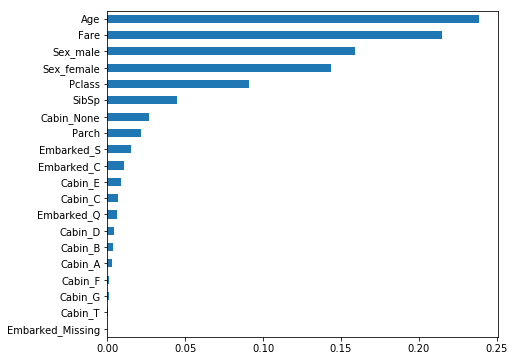

In [48]:
## Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=True, inplace=True)
feature_importances.plot(kind="barh", figsize=(7,6))

## Find which variable is very inmportant

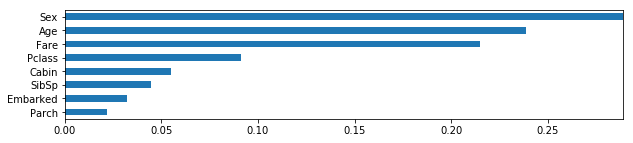

In [79]:
## Complex version that shows the summary view
def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Georf
    Graph the feature importances of a random decision forest using horizontal bar chart.
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed
    featue_name = A list of the names of those features, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, 0.05 default
    width = figue width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables ie.g ["day_] would summarize all days
    """
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        ## some dummy columns need to be summarized
        for col_name in summarized_columns:
            ## sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            ## now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
            ##lastly, read the summarized field
            feature_dict[col_name] = sum_value
            
    v_value = list(feature_dict.values())
    results = pd.Series(v_value, index=feature_dict.keys())
    results.sort_values(ascending=True, inplace=True)
    results.plot(kind="barh", figsize=(width, len(results)/4), xlim=(0, x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

## Parameter tests

## n_jobs

In [80]:
%%timeit
model= RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 2.44 s per loop


In [81]:
%%timeit
model= RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 1.64 s per loop


## n_estimators

30 trees
C-stat : 0.8538704076524037

50 trees
C-stat : 0.8606983457429244

100 trees
C-stat : 0.8635211282608464

200 trees
C-stat : 0.8621922900755228

500 trees
C-stat : 0.863739494455629

1000 trees
C-stat : 0.8640430767264244

2000 trees
C-stat : 0.8634492271967107



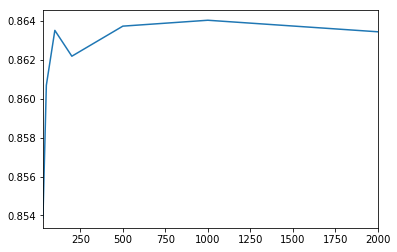

In [82]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print(trees, "trees")
    roc = roc_auc_score(y, model.oob_prediction_)
    print("C-stat :", roc)
    results.append(roc)
    print("")
    
pd.Series(results,n_estimator_options).plot()

## max_features

auto option
C-stat : 0.8640430767264244

None option
C-stat : 0.8640430767264244

sqrt option
C-stat : 0.8633746631301995

log2 option
C-stat : 0.8633746631301995

0.9 option
C-stat : 0.8635344432727234

0.2 option
C-stat : 0.8633746631301995



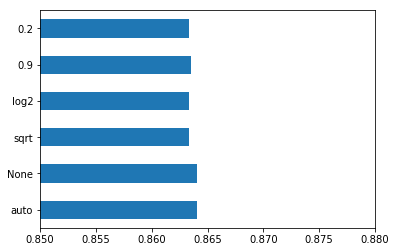

In [85]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    print(max_features, "option")
    roc = roc_auc_score(y, model.oob_prediction_)
    print("C-stat :", roc)
    results.append(roc)
    print("")
    
pd.Series(results,max_features_options).plot(kind='barh', xlim=(.85, .88))

## min_samples_leaf

0.2 min_samples
C-stat : 0.8640430767264244

0.2 min_samples
C-stat : 0.8696540227313881

0.2 min_samples
C-stat : 0.8715713844416749

0.2 min_samples
C-stat : 0.87347809414246

0.2 min_samples
C-stat : 0.8742690058479532

0.2 min_samples
C-stat : 0.8740293356341673

0.2 min_samples
C-stat : 0.8733049989880591

0.2 min_samples
C-stat : 0.871866977705344

0.2 min_samples
C-stat : 0.8692945174107096

0.2 min_samples
C-stat : 0.8674304157479309



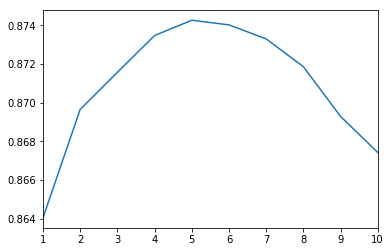

In [88]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto",
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print(max_features, "min_samples")
    roc = roc_auc_score(y, model.oob_prediction_)
    print("C-stat :", roc)
    results.append(roc)
    print("")
    
pd.Series(results,min_samples_leaf_options).plot()

# Final Model

In [89]:
model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto",
                                  min_samples_leaf=5)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print("C-stat :", roc)

C-stat : 0.8742690058479532


# 2- Pime Indians Diabetes Data

In [13]:
# load pima indians dataset
X = pd.read_csv("data/pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
y = X.pop('Outcome')   # select only the last column

## Model 
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print("C-stat :", roc_auc_score(y, model.oob_prediction_))

C-stat : 0.8231156716417911


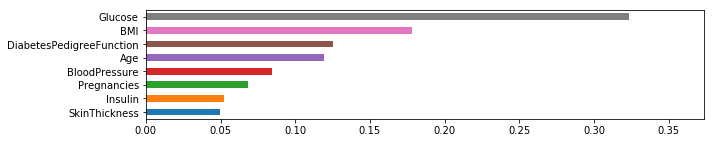

In [16]:
## Check importance of all variables
## Complex version that shows the summary view
def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Georf
    Graph the feature importances of a random decision forest using horizontal bar chart.
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed
    featue_name = A list of the names of those features, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, 0.05 default
    width = figue width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables ie.g ["day_] would summarize all days
    """
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        ## some dummy columns need to be summarized
        for col_name in summarized_columns:
            ## sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            ## now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
            ##lastly, read the summarized field
            feature_dict[col_name] = sum_value
            
    v_value = list(feature_dict.values())
    results = pd.Series(v_value, index=feature_dict.keys())
    results.sort_values(ascending=True, inplace=True)
    results.plot(kind="barh", figsize=(width, len(results)/4), xlim=(0, x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=None)

## Parameter tests

### Parameters that will make the model better
* n_estimators : The number of trees in the forest. Choose as high of a number as your computer can handle.
    
* max_features: The number of features to consider when looking for the best split. Try ["auto","None","sqrt","log2",0.9, and 0.2]
    
* min_samples_leaf: The minimum number of samples on newly created leaves. Try [1,2,3]. If 3 is the best, try higher numbers such as 1 through 10.

Parameters that will make the model better
    <h4> - n_estimators:</h4>The number of trees in the forest. Choose as high of a number as your computer can handle.<h4> - max_features:</h4> The number of features to consider when looking for the best split. Try ["auto","None","sqrt","log2",0.9, and 0.2] <h4> - min_samples_leaf:</h4> The minimum number of samples on newly created leaves. Try [1,2,3]. If 3 is the best, try higher numbers such as 1 through 10. 

## n_jobs

In [18]:
%%timeit
model = RandomForestRegressor(100, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

253 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

193 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## n_estimators

30 trees
C-stat : 0.8080261194029851

50 trees
C-stat : 0.8156791044776118

100 trees
C-stat : 0.8231156716417911

200 trees
C-stat : 0.8271716417910449

500 trees
C-stat : 0.8242649253731342

1000 trees
C-stat : 0.8239589552238806

2000 trees
C-stat : 0.8232014925373135



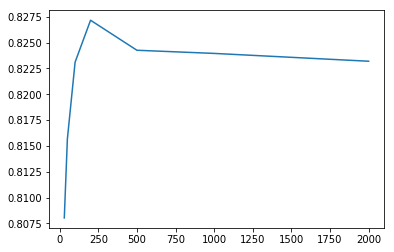

In [20]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print(trees, "trees")
    roc = roc_auc_score(y, model.oob_prediction_)
    print("C-stat :", roc)
    results.append(roc)
    print("")
    
pd.Series(results,n_estimator_options).plot()

## max_features

auto option
C-stat : 0.8239589552238806

None option
C-stat : 0.8239589552238806

sqrt option
C-stat : 0.8257537313432837

log2 option
C-stat : 0.8265820895522389

0.9 option
C-stat : 0.8242537313432836

0.2 option
C-stat : 0.8217873134328358



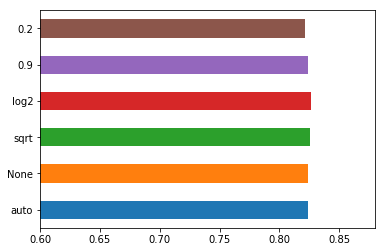

In [25]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    print(max_features, "option")
    roc = roc_auc_score(y, model.oob_prediction_)
    print("C-stat :", roc)
    results.append(roc)
    print("")
    
pd.Series(results,max_features_options).plot(kind='barh', xlim=(.60, .88))

## min_samples_leaf

0.2 min_samples
C-stat : 0.8343358208955224

0.2 min_samples
C-stat : 0.8369701492537314

0.2 min_samples
C-stat : 0.8340000000000001

0.2 min_samples
C-stat : 0.8334626865671642

0.2 min_samples
C-stat : 0.8351940298507463

0.2 min_samples
C-stat : 0.8343880597014925

0.2 min_samples
C-stat : 0.8355522388059702

0.2 min_samples
C-stat : 0.8347313432835822

0.2 min_samples
C-stat : 0.8337686567164179

0.2 min_samples
C-stat : 0.8337313432835821

0.2 min_samples
C-stat : 0.832589552238806

0.2 min_samples
C-stat : 0.8343134328358209

0.2 min_samples
C-stat : 0.8339626865671643

0.2 min_samples
C-stat : 0.8337388059701494

0.2 min_samples
C-stat : 0.8322835820895522



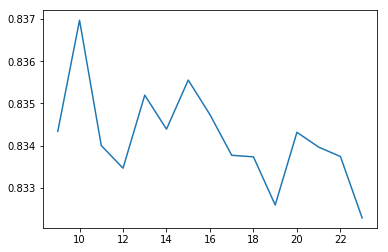

In [29]:
results = []
min_samples_leaf_options = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=200, 
                                  oob_score=True, n_jobs=-1, 
                                  random_state=42, 
                                  max_features="log2",
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print(max_features, "min_samples")
    roc = roc_auc_score(y, model.oob_prediction_)
    print("C-stat :", roc)
    results.append(roc)
    print("")
    
pd.Series(results,min_samples_leaf_options).plot()

## Final Model for Pime Indians Diabetes is :

In [30]:
model = RandomForestRegressor(n_estimators=200, 
                                  oob_score=True, n_jobs=-1, 
                                  random_state=42, 
                                  max_features="log2",
                                  min_samples_leaf=10)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print("C-stat :", roc) # previous C-stat was : 0.8231156716417911

C-stat : 0.8369701492537314


In [31]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

In [32]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [41]:
model.predict(X_test)

array([0.02655723, 0.82513154, 0.49463067, 0.09740894, 0.48777624,
       0.58375293, 0.08582962, 0.20986752, 0.85278987, 0.16380067,
       0.79879172, 0.07723713, 0.72324919, 0.76980821, 0.23212321,
       0.21650016, 0.26372408, 0.35987717, 0.17112097, 0.1925085 ,
       0.49102919, 0.16888183, 0.80768659, 0.71054993, 0.09897402,
       0.11700951, 0.04280874, 0.60729282, 0.46147724, 0.33971066,
       0.44748757, 0.19645851, 0.32618756, 0.42847665, 0.05162799,
       0.39100294, 0.51606399, 0.27591252, 0.69375803, 0.39234328,
       0.65187705, 0.79579656, 0.56375624, 0.00363254, 0.22238302,
       0.15934264, 0.54925551, 0.55121018, 0.23436321, 0.47118754,
       0.03429219, 0.04622299, 0.51339755, 0.24023961, 0.64737683,
       0.43391975, 0.18592215, 0.05160504, 0.3689508 , 0.32481955,
       0.16915486, 0.71654782, 0.216906  , 0.6366525 , 0.68000947,
       0.62803414, 0.2528557 , 0.57757257, 0.85298165, 0.60793449,
       0.84210711, 0.73884382, 0.1665512 , 0.26719502, 0.16628